In [449]:
import pymc3 as pm 
import numpy as np 
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd 
import os 
import theano
from theano import shared, tensor as tt

plt.style.use('classic')
# Plotting font size and family 
########################################
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

########################################

In [450]:
import theano 
import pymc3 as pm
from scipy import stats
from theano import shared, tensor as tt
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False
    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)
def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.

    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5
    # cast tau and sigma to float in a way that works for both np.arrays
    # and pure python
    tau = 1. * tau
    sigma = 1. * sigma
    return floatX(tau), floatX(sigma)
class Sum_of_Squares(pm.distributions.Continuous):
    def __init__(self, mu=0, sigma=None, tau=None, sd=None, **kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)
        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau
        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')
        super().__init__(**kwargs)
    def random(self, point=None, size=None):
        
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)
    def logp(self, value):
        """
        Sum of Squares
        
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu
        
        logp = - tt.sqr(value - mu)/(2.0 * sigma *sigma)
        return logp.sum()

In [451]:
# Data
cwd = os.chdir("/Users/jackcarter/Downloads")
df1 = pd.read_csv("Kula_Muscovite_3_data.csv", engine = "python")

# DataFrame for Kula et al., (2010) Muscovite Mixture 3

In [452]:
df1

,temp3,time3,ar393,ar403,age3,age_err3
0,725,12,109.82,5575.05,90.79,0.63
1,775,12,98.11,2988.19,92.66,0.52
2,820,12,212.02,6018.54,91.57,0.50
3,850,12,340.72,8783.32,90.59,0.49
4,875,12,493.39,13065.36,94.46,0.51
5,900,12,468.74,12375.78,94.32,0.51
6,915,12,258.02,6884.24,94.63,0.51
7,930,12,185.93,5007.06,95.32,0.51
8,945,12,132.22,3591.60,95.79,0.51
9,960,12,91.03,2434.70,94.06,0.51


In [453]:
# Sort data into variable names
temp1 = df1['temp3'].values
time1 = df1['time3'].values
a391 = df1['ar393'].values
a401 = df1['ar403'].values
age1 = df1['age3'].values
age1_err = df1['age_err3'].values

In [454]:
# Shared variable for modelling 
data = age1
err = age1_err
age_err = shared(err*2)

In [455]:
def fracrelx(Ea, D0, a, temp, time): 
    R = 8.314e-3
    D0t = (D0/(a**2))*np.exp(-Ea/(R*temp))*time
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    q1 = (6./(np.pi**(1.5)))*np.sqrt((np.pi**2)*D0t)
    
    q2 = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)\
    - (3./(np.pi**2)) *((np.pi**2)* D0t)
    
    q3 = 1 - (6./(np.pi**2)) *np.exp(-(np.pi**2)*D0t)
     
    Q = tt.switch(q <= 0.9, q2, q3)
    T = tt.switch(q < 0.1, q, Q)
    
    return T

In [456]:
def Increment(ea, d0, a, temp, t):
    R = 8.314e-3
    
    D0t = (d0/(a**2))*np.exp(-ea/(R*temp))*t
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    aa1 = np.sqrt(np.pi) * R * temp**2
    bb1 = d0*np.exp(-ea/(R*temp))*t
    z1 = (3*ea *np.sqrt(bb1/a**2))/aa1
    

    aa2 = np.sqrt(np.pi) * R *temp**2
    bb2 = d0*np.exp(-ea/(R*temp))*t
    z2 = (3*ea*(np.sqrt(bb2/a**2) - np.sqrt(np.pi)*bb2/a**2))/aa2
      
    
    aa3 = a**2 * R * temp**2
    bb3 = d0*np.exp(-ea/(R*temp))*t
    z3 = 6 * d0 * ea * t * np.exp((-np.pi**2 * bb3/a**2) - ea/(R*temp))/aa3

    
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    
    T = tt.switch(q < 0.1, z1, Q)
    
    
    return T

In [457]:
def frel_data(x): 
    y = np.cumsum(x) 
    dd = y/y.max()
    return dd

# For plotting (%)
x = 100 *frel_data(a391)

# The Age Spectra and Fractional Release Curves

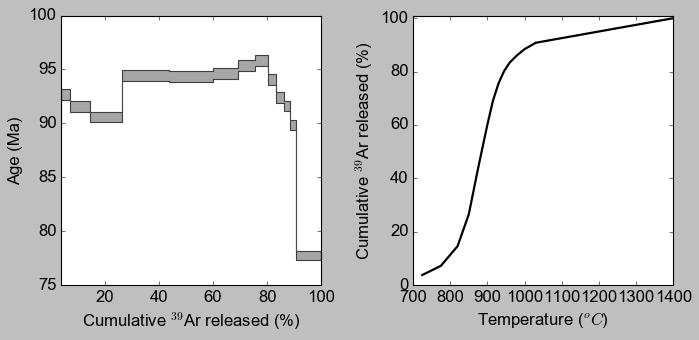

In [458]:
fig, ax = plt.subplots(1,2, figsize = (9, 4.5))

ax[0].fill_between(x, data - err, data + err, 
                  step = 'pre', 
                  color = 'grey', alpha = 0.7, 
                  edgecolor = 'k')
ax[0].set_xlim(x.min(), x.max())

ax[0].set_ylabel('Age (Ma)')
ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')

ax[1].plot(temp1,x, lw = 2, 
          color= 'k')
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperature ($^{o}C$)')
ax[1].set_ylim(0, 101)
plt.tight_layout()

In [459]:
# Data for model
# Fractional release Data
data_f = x/100

# Temperature in Kelvin
tempk = temp1 + 273.15

# Time in seconds
t_obs = time1 * 60

# Length of Data
N = data.shape[0]

# Gas Constant in kJ/mol
R = 8.314e-3

In [460]:
# Define Model Name
BAr = pm.Model() 
# Defining model - 
# everyting indented is 
# constructed within the
# model
with BAr:
    # Volume Fraction 
    phi = pm.Dirichlet('phi', a = np.array([0.25, 0.75]), 
                      shape = 2, 
                      testval = (0.25, 0.75))
    
    # Potential Bounds for the mixing fraction of each component
    phi_c = pm.Potential('phi_c', 
                        tt.switch(phi[0] < 0.2, 
                                  -np.inf, 0) + 
                        tt.switch(phi[0] > 0.3, 
                                 -np.inf, 0))

    
    # Diffusion Kinetics 
    # Mineral 
    # Activation Energy 
    ea1 = pm.Normal('ea1', 
                    mu = 260,
                    sd = 6)
    
    ea2 = pm.Normal('ea2', 
                    mu = 260, 
                    sd = 6)
    
    # Frequency Factor 
    d01 = pm.Lognormal('d01',
                     mu = 2,
                     sd = 3)
    d02 = pm.Lognormal('d02',
                     mu = 2,
                     sd = 3)

    
    # Grain size (microns)
    a1 = pm.Uniform('a1',
                    lower = 0.0177/2, upper = 0.025/2)
    
    a2 = pm.Uniform('a2',
                    lower = 0.0177/2, upper = 0.025/2)
     

In [461]:
with BAr: 
    # Cumulative Release component 1
    c1 = fracrelx(ea1,d01, 
                  a1, tempk, t_obs)
    # Cumulative Release component 2
    c2 = fracrelx(ea2, d02, 
                  a2, tempk, t_obs)
    # Recasting mixing fraction for easier construction of 
    # Equation 
    m1 = phi[0]
    
    m2 = phi[1]
    
    # Cumulative Release Model 
    model1 = m1*c1 + m2*c2
    
# Monotonicity 
# Constraints
######################################################################
######################################################################
######################################################################
    for i in range(len(tempk) - 1): 
        Frel_bound_a = pm.Potential(f'f_bound_a{i}', 
                                 tt.switch(c1[i +1] - c1[i] < 0, 
                                          -np.inf, 0)) 
        Frel_bound_b = pm.Potential(f'f_bound_b{i}', 
                                 tt.switch(c2[i +1] - c2[i] < 0, 
                                          -np.inf, 0)) 

        
        
    for i in range(len(data) - 1): 
        f_con_mu = pm.Potential(f'f_bound_mu{i}', 
                               tt.switch(model1[i + 1]-model1[i] < 0, 
                                        -np.inf, 0))  
######################################################################
######################################################################    
######################################################################    

In [462]:
with BAr: 
    # Age of each component in the model 
    age1 = pm.Uniform('age1', lower = 0.0,
                      upper = 4600, 
                     testval = 200)
    age2 = pm.Uniform('age2', lower = 0.0,
                      upper = 4600, 
                     testval = 100)
    
    age_order = pm.Potential('age_order', 
                            tt.switch(age1 - age2 < 0, 
                                     -np.inf, 0))
    

In [463]:
with BAr: 
    # Incremental Curves of each component
    X = Increment(ea1, d01, a1,
                  tempk, t_obs)
    Y = Increment(ea2, d02, a2,
                  tempk, t_obs)
     
    # Multi-component ArAr age equation
    model2 = ((m1*X)/(m1*X + m2*Y))*age1 \
    + ((m2*Y)/(m1*X + m2*Y))*age2


In [464]:
with BAr: 
    # Cumulative Release Error 
    f_err = pm.HalfNormal('f_err', sd  = 0.5, 
                         shape = N)
    
    # Age Error 
    age_err_model = pm.HalfNormal('age_err_model', 
                                 sd =  5,
                                 shape = N)

# Models
* Create each model as a deterministic variable 
* By doing this we can do maths inside the sampling 
* At the end of the trace the mean and 95% credible interval of each of these parameters will be the mean and posterior models of the cumulative release and age spectra

In [465]:
# Models for plotting 
with BAr: 
    f_model = pm.Deterministic('f_model', 
                               model1)
    age_model = pm.Deterministic('Age_Model', 
                                model2)

# Likelihoods

In [466]:
with BAr: 
    # Cumulative Release Likelihood 
    L1 = pm.Normal('L1', mu = model1, sd = f_err, 
                 observed = data_f)
    

In [467]:
with BAr: 
    # Age Spectra Likelihood 
    L2 = Sum_of_Squares('L2', model2, 
                           age_err_model, 
                           observed = data)

# Log Probability of test point 
* check for inf

In [468]:
BAr.check_test_point()

L1                     -13.85
L2                    -491.62
a1_interval__           -1.39
a2_interval__           -1.39
age1_interval__         -3.18
age2_interval__         -3.85
age_err_model_log__    -10.78
d01_log__               -2.02
d02_log__               -2.02
ea1                     -2.71
ea2                     -2.71
f_err_log__            -10.78
phi_stickbreaking__     -2.05
Name: Log-probability of test_point, dtype: float64

In [482]:
SAMPLES = 200000
BURN = 250000


with BAr: 
    step1 = pm.NUTS([ea1, ea2], 
                   target_accept = 0.83)
    
    step2 = pm.Metropolis([phi, 
                           a1, a2, 
                          age1, age2,  
                         d01, d02, 
                          f_err, age_err])
    
    trace = pm.sample(SAMPLES, tune = BURN, 
                      step = pm.Metropolis(), 
                     cores = 2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [age_err_model]
>Metropolis: [f_err]
>Metropolis: [age2]
>Metropolis: [age1]
>Metropolis: [a2]
>Metropolis: [a1]
>Metropolis: [d02]
>Metropolis: [d01]
>Metropolis: [ea2]
>Metropolis: [ea1]
>Metropolis: [phi]
Sampling 2 chains: 100%|██████████| 900000/900000 [1:04:46<00:00, 231.60draws/s]
The number of effective samples is smaller than 10% for some parameters.


# Traceplot

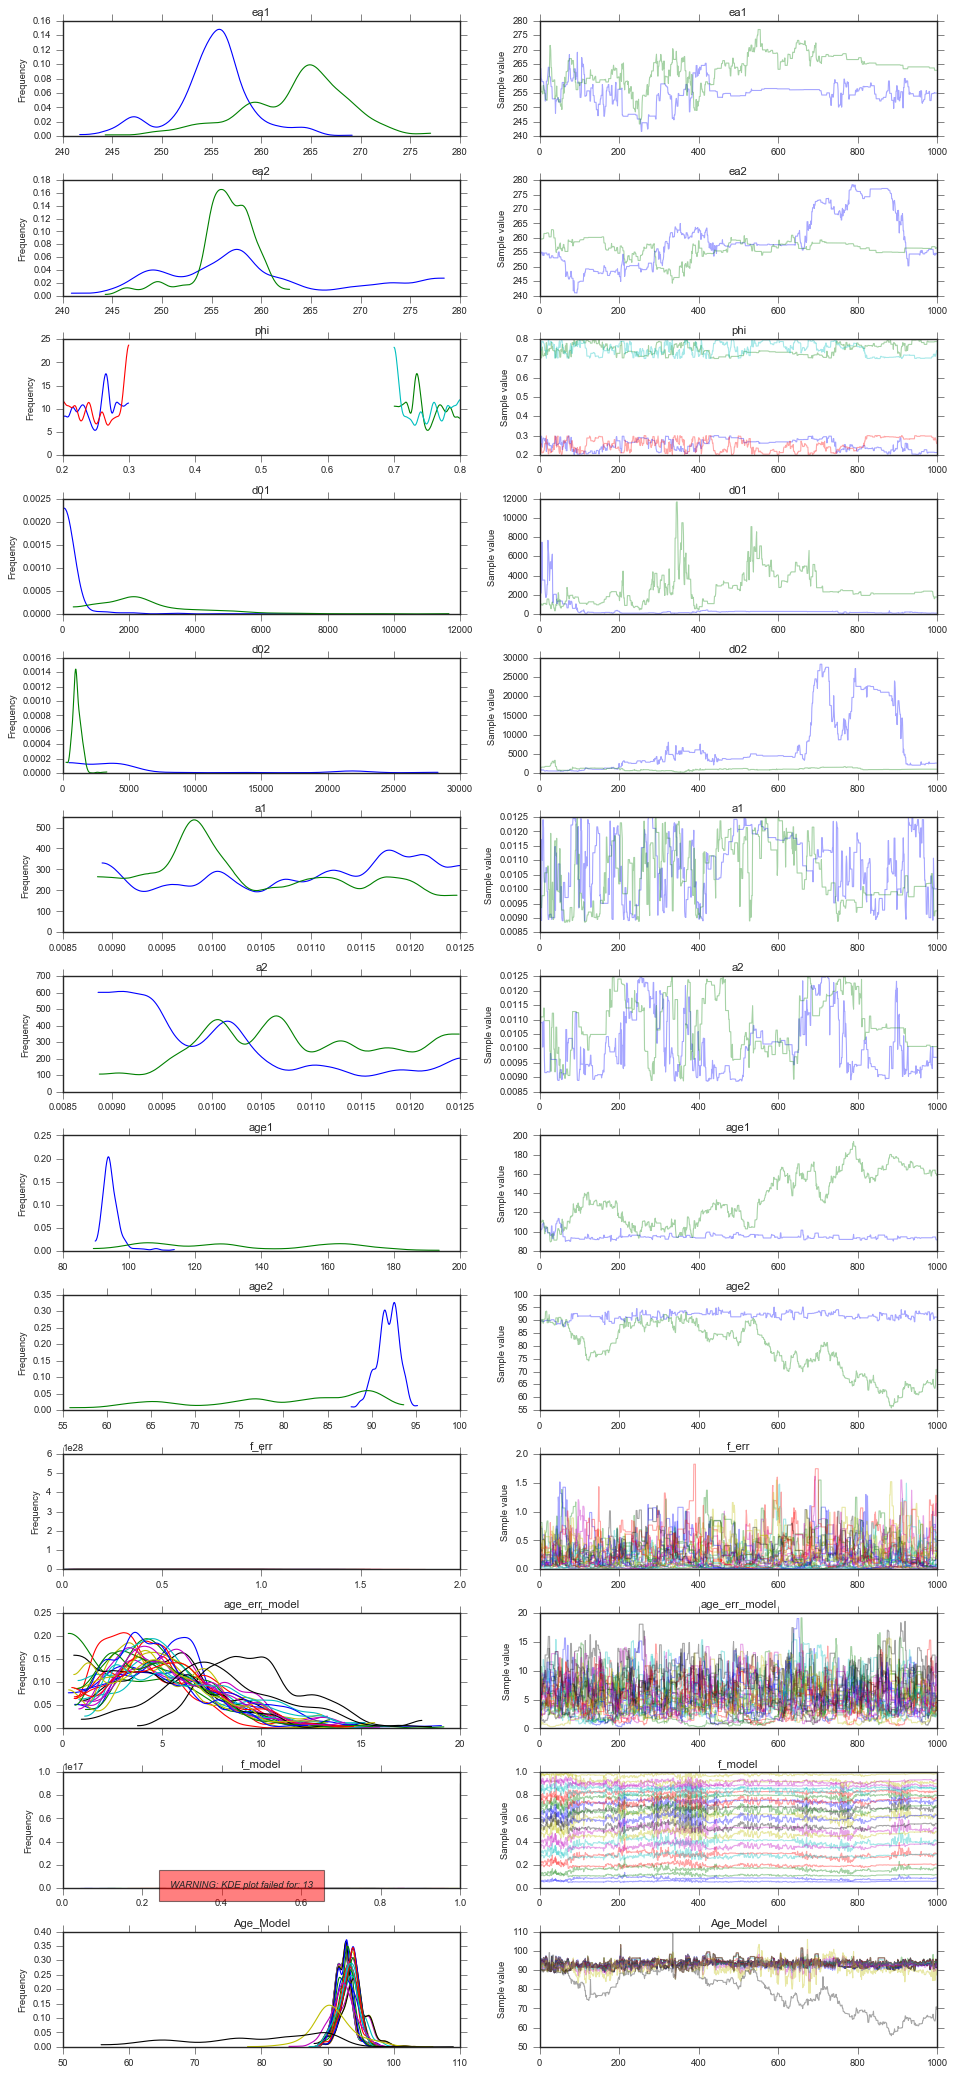

In [483]:
sns.set_style('ticks')
pm.traceplot(trace[-1000:]); 

In [484]:
print(trace['age1'][-1000:].mean(axis = 0))
print(trace['age2'][-1000:].mean(axis = 0))



print(2*np.std(trace['age1'][-1000:]))
print(2*np.std(trace['age2'][-1000:]))

134.64915735356115
78.7985656031059
53.24214117875507
19.905063701431892


## Plot the Mixing Fractions

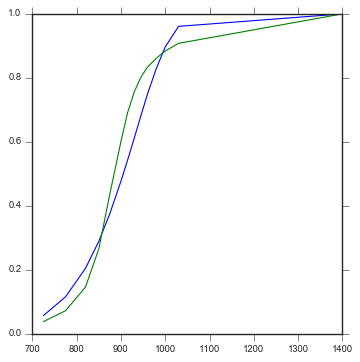

In [485]:
x1 = trace['f_model'][-20000:].mean(axis = 0)
plt.figure(figsize = (5,5))
plt.plot(temp1, x1)
plt.plot(temp1, data_f)

# 95% Credible Interval 

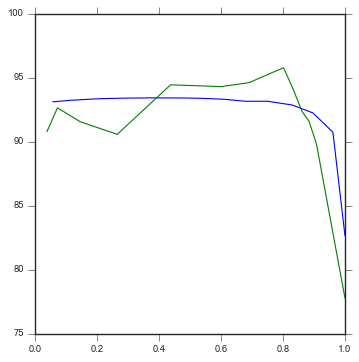

In [486]:
x2 = trace['Age_Model'][-20000:].mean(axis = 0)
plt.figure(figsize = (5,5))
plt.plot(x1, x2)
plt.plot(data_f, data)

In [487]:
low1, high1 = np.percentile(trace['f_model'][-10000:], [2.5, 97.5], axis = 0)
low2, high2 = np.percentile(trace['Age_Model'][-10000:], [2.5, 97.5], axis = 0)

## Mean Predictive Models
* Plot these to check the mean posterior and the deviation from data

In [488]:
Z1 = trace['f_model'][-10000:].mean(axis = 0)
Z2 = trace['Age_Model'][-10000:].mean(axis = 0)

# Fractional release plot

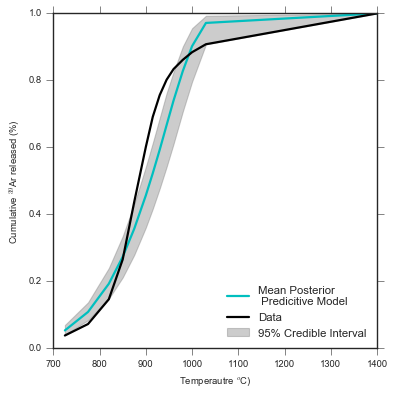

In [489]:

plt.figure(figsize = (5,5))
plt.fill_between(temp1, low1, high1, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
plt.plot(temp1, Z1, 'c', lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')

plt.plot(temp1, data_f, lw = 2, color= 'k', 
        label = 'Data')
plt.ylabel('Cumulative $^{39}$Ar released (%)')
plt.xlabel('Temperautre $^{o}$C)')
plt.legend(loc = 'best')
plt.tight_layout()

## Age Spectra plot

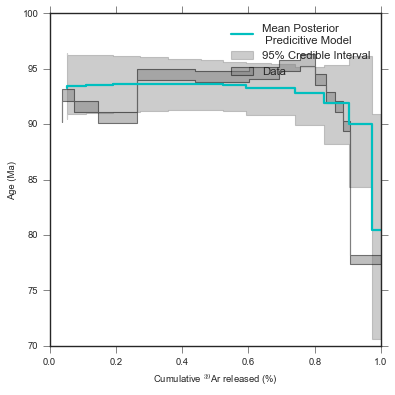

In [490]:
plt.figure(figsize = (5,5))
plt.fill_between(Z1, low2, high2, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval', 
                step = 'pre')
plt.plot(Z1, Z2, 'c', 
        lw = 2, 
        label = 'Mean Posterior \n Predicitive Model', 
        drawstyle = 'steps')
plt.fill_between(data_f, data - err, data + err, 
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')

plt.xlabel('Cumulative $^{39}$Ar released (%)')
plt.ylabel('Age (Ma)')
plt.legend(loc = 'best')
plt.tight_layout()

# Combined

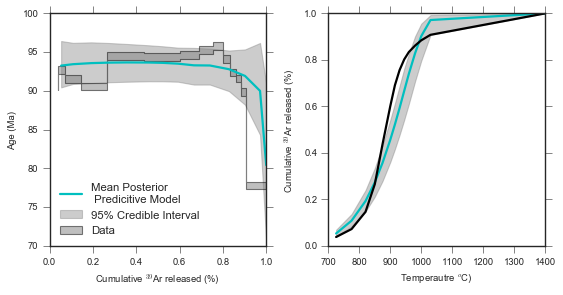

In [491]:
### AGE SPECTRA
fig, ax = plt.subplots(1,2, figsize = (7.1, 3.75))

ax[0].fill_between(Z1, low2, high2, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
ax[0].plot(Z1, Z2, 'c', 
        lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')
ax[0].fill_between(data_f, data - err, data + err, 
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')

ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')
ax[0].set_ylabel('Age (Ma)')
ax[0].legend(loc = 'best')



# Fractional Release
ax[1].fill_between(temp1, low1, high1, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
ax[1].plot(temp1, Z1, 'c', lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')

ax[1].plot(temp1, data_f, lw = 2, color= 'k', 
        label = 'Data')
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperautre $^{o}$C)')



plt.tight_layout()

# Log Likelihood of each Drawn Sample
* Calculation of logp for each draw in trace
* Cell below

In [479]:
ml = BAr.logp
logp = [ml(i) for i in trace]

Text(0.5, 0, 'Iteration/10')

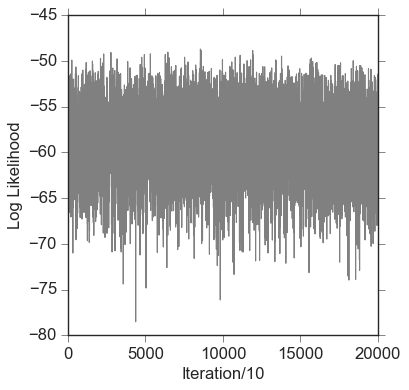

In [480]:
sns.set_style('ticks')
plt.figure(figsize = (5,5))
plt.plot(logp[::10], color = 'grey')
plt.ylabel('Log Likelihood')
plt.xlabel('Iteration/10')

# Log Likelihood and Age trace from paper

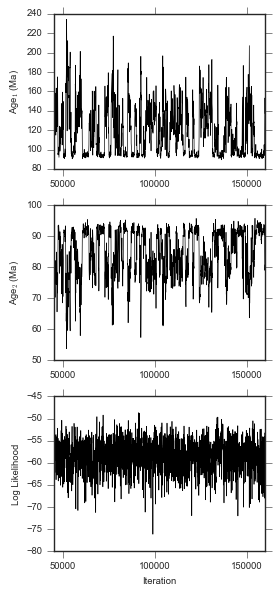

In [481]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8.5}

plt.rc('font', **font)
import seaborn as sns 
fig, ax = plt.subplots(3,1, figsize = (3.54331, 7.48031))
x = np.linspace(40000,159999, len(trace['age1'][-160000::100]))
xz = np.linspace(40000, 160000, len(logp[::100]))
ax[0].plot(x,trace['age1'][-160000::100], 
          color = 'k', lw = 0.6)
ax[1].plot(x,trace['age2'][-160000::100], 
          color = 'k', lw = 0.6)
ax[2].plot(xz,logp[::100], color = 'k', 
          lw= 0.6)

ax[2].set_xlabel('Iteration')


ax[0].set_ylabel('Age$_1$ (Ma)')
ax[1].set_ylabel('Age$_2$ (Ma)')
ax[2].set_ylabel('Log Likelihood')
ax[0].locator_params(axis='x', nbins=5)
ax[1].locator_params(axis='x', nbins=5)
ax[2].locator_params(axis='x', nbins=5)
#labels = ['45000', '47500', '50000']
ax[0].set_xlim(45000, 160000)
ax[1].set_xlim(45000, 160000)
ax[2].set_xlim(45000, 160000)
#ax[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#ax[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#ax[2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()
#ax[0].set_ylim(18, 30)
#ax[1].set_ylim(0.4, 2)
#ax[2].set_ylim(-750, -650)
plt.savefig('Log_like_trace.pdf')

# Save to DataFrames for plotting

In [39]:
df = pd.DataFrame({"age_model": Z2, 
                  "age_model_low": low2, 
                  "age_model_high": high2, 
                  "frel_model": Z1, 
                  "frel_model_low": low1, 
                  "frel_model_high": high1, 
                  "age_data": data, 
                  "age_err": age1_err, 
                   "frel_data": data_f, 
                  "temp": temp1})

# Trace_DataFrame
df1 = pm.trace_to_dataframe(trace)

In [40]:
# Put results into 
# dataframe for posterior plots
df.to_csv('kula_1_muscovite_posterior.csv')
df1.to_csv('kula_1_muscovite_trace.csv')

In [43]:
# Pair Grid trace plot
dfp = pd.DataFrame({"age1":df1['age1'].values, 
                   "age2": df1['age2'].values, 
                   "ea1":df1['ea1'].values, 
                   "ea2":df1['ea2'].values, 
                   "d01":df1['d01'].values, 
                   "d02":df1['d02'].values})

Text(0.5, 112.99999999999989, 'E$_a$2 (kjmol$^{-1}$)')

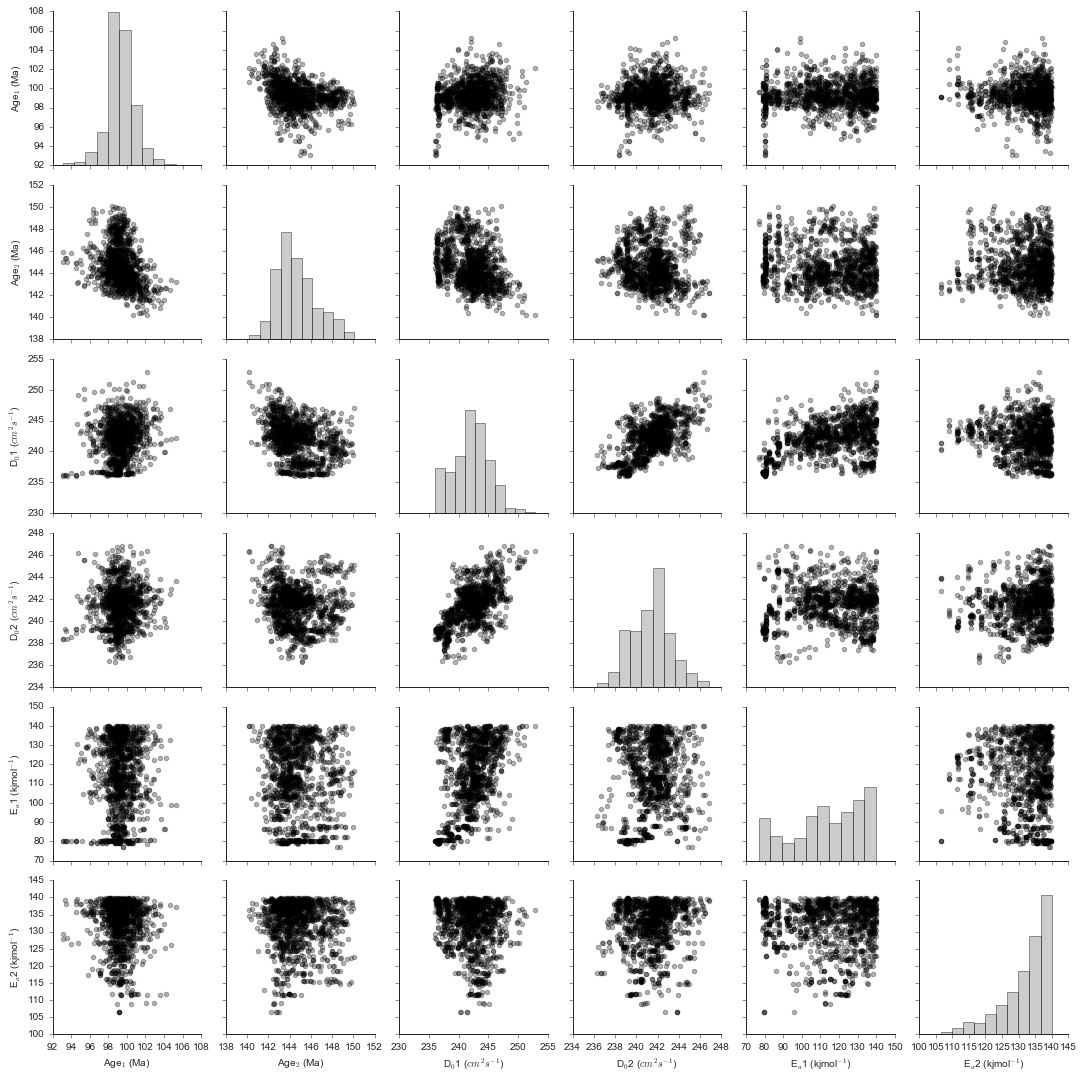

In [44]:
g = sns.PairGrid(dfp[-5000::4])
g = g.map_diag(plt.hist, facecolor = 'grey', edgecolor = 'k', 
              alpha = 0.4)
g = g.map_offdiag(plt.scatter, alpha = 0.3, color = 'k')


# Y_AXIS LABELS

g.axes[0,0].set_ylabel('Age$_1$ (Ma)')
g.axes[1,0].set_ylabel('Age$_2$ (Ma)')
g.axes[2,0].set_ylabel('D$_0$1 ($cm^{2}s^{-1}$)')
g.axes[3,0].set_ylabel('D$_0$2 ($cm^{2}s^{-1}$)')
g.axes[4,0].set_ylabel('E$_a$1 (kjmol$^{-1}$)')
g.axes[5,0].set_ylabel('E$_a$2 (kjmol$^{-1}$)')



# X_AXIS LABELS

g.axes[5,0].set_xlabel('Age$_1$ (Ma)')
g.axes[5,1].set_xlabel('Age$_2$ (Ma)')
g.axes[5,2].set_xlabel('D$_0$1 ($cm^{2}s^{-1}$)')
g.axes[5,3].set_xlabel('D$_0$2 ($cm^{2}s^{-1}$)')
g.axes[5,4].set_xlabel('E$_a$1 (kjmol$^{-1}$)')
g.axes[5,5].set_xlabel('E$_a$2 (kjmol$^{-1}$)')

In [45]:
dfx = dfp[-5000::4]

dfx.to_csv('kula1_pairgrid.csv')